# Comparison of the supervised models
    All the hyperparmeters values were entered below.
    The data was scaled.
    The AUC/ROC was calculated.
    The Accuracy was calculated for each.
    The best model was picked and the Recall and Prcision was calculated.
    The feature importance was also calculated.

    1.) Random Forest
    2.) Random Forest ADA Boost
    3.) Extreme Gradient Boost

In [31]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import math

from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from time import time
from IPython.display import display
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import plot_importance

from sklearn.metrics import mean_squared_error
sns.set(style="darkgrid")


%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('lending_club_le.csv', index_col=0)
y = df['good_loan_status']
X = df.drop(['good_loan_status'], axis=1)

In [3]:
X.shape, y.shape

((73318, 37), (73318,))

In [4]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((58654, 37), (14664, 37), (58654,), (14664,))

------

# Model comparison of accuracy score

These are the tuned values from the previous notebook

In [6]:
rf_final = RandomForestClassifier(max_depth=6,
                                  min_samples_leaf=60,
                                  min_samples_split=50,
                                  max_features=8,
                                  n_estimators=20)

ada_final = AdaBoostClassifier(base_estimator=rf_final,
                               n_estimators=8)

xgb_final = XGBClassifier(max_depth=3,
                          n_estimators=5,
                          learning_rate=1e-05,
                          subsample=0.1,
                          colsample_bytree=0.001,
                          colsample_bylevel=0.0001)

In [7]:
# Let's see the accuracy scores for all of our models.
models = []
results = []
names = []
print('\t   Accuracy\n\t score\t  std')


models.append(('RFC', make_pipeline(preprocessing.StandardScaler(),
                                    PCA(n_components=33),
                                    RandomForestClassifier(max_depth=6,
                                                           min_samples_leaf=60,
                                                           min_samples_split=50,
                                                           max_features=8,
                                                           n_estimators=20))))

models.append(('ADA', AdaBoostClassifier(base_estimator=rf_final,
                                         n_estimators=8)))

models.append(('XGB', make_pipeline(preprocessing.StandardScaler(),
                                    PCA(n_components=33),
                                    XGBClassifier(max_depth=3,
                                                  n_estimators=5,
                                                  learning_rate=1e-05,
                                                  subsample=0.1,
                                                  colsample_bytree=0.001,
                                                  colsample_bylevel=0.0001))))


for name, model in models:
    kfold = model_selection.KFold(n_splits=3, random_state=42)
    cv_results = model_selection.cross_val_score(model,
                                                 X_train,
                                                 y_train,
                                                 cv=3,
                                                 scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%.4f (%.4f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
print('----------------------------------------------------------\n')
for name, model in models:
    model.fit(X_train, y_train)
    y_pred2 = model.predict(X_test)
    names.append(name)

    print('\n', name, '\nconfusion matrix \n',
          confusion_matrix(y_test, y_pred2))
    print('\nholdout accuracy score: ', accuracy_score(y_test, y_pred2))
    print('\ncross validation scores: ',
          cross_val_score(model, X_test, y_test, cv=3))
    print('\n', classification_report(y_test, y_pred2))

    mse = math.sqrt(mean_squared_error(y_test, y_pred2))
    print("MSE: %.4f RMSE: %.4f" % (mse, np.sqrt(mse)))
    print('----------------------------------------------------------\n')

	   Accuracy
	 score	  std
RFC:	0.8294 (0.0012)
ADA:	0.8707 (0.0010)
XGB:	0.7733 (0.0002)
----------------------------------------------------------


 RFC 
confusion matrix 
 [[  866  2420]
 [    7 11371]]

holdout accuracy score:  0.83449263502455

cross validation scores:  [0.83411741 0.82405892 0.83445877]

               precision    recall  f1-score   support

           0       0.99      0.26      0.42      3286
           1       0.82      1.00      0.90     11378

   micro avg       0.83      0.83      0.83     14664
   macro avg       0.91      0.63      0.66     14664
weighted avg       0.86      0.83      0.79     14664

MSE: 0.4068 RMSE: 0.6378
----------------------------------------------------------


 ADA 
confusion matrix 
 [[ 1524  1762]
 [  107 11271]]

holdout accuracy score:  0.872545008183306

cross validation scores:  [0.87543465 0.86497545 0.87292818]

               precision    recall  f1-score   support

           0       0.93      0.46      0.62      3286


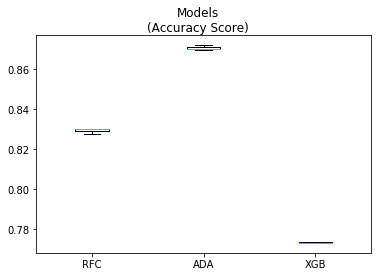

In [8]:
# Let's take a look at the Accuracy scores on a box plot
fig = plt.figure()
sns.set(style="darkgrid")
fig.suptitle('Models\n(Accuracy Score)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

_The models produce a ~80% accuracy with RFC edging out XGB.  All models predict many false positives than false negatives.  I would rather make a mistake of false positives than false negatives. The weighted averages for the models are very stable at so the models don't seem to be overfit._

----

# Model comparison of ROC-AUC score

In [9]:
# ROC-AUC scores for all of our models.
print('\t   ROC/AUC\n\t score\t  std')
results = []
names = []
names1 = []
models = []

models.append(('RFC', make_pipeline(preprocessing.StandardScaler(),
                                    PCA(n_components=33),
                                    RandomForestClassifier(max_depth=6,
                                                           min_samples_leaf=60,
                                                           min_samples_split=50,
                                                           max_features=8,
                                                           n_estimators=20))))

models.append(('ADA', AdaBoostClassifier(base_estimator=rf_final,
                                         n_estimators=8)))

models.append(('XGB', make_pipeline(preprocessing.StandardScaler(),
                                    PCA(n_components=33),
                                    XGBClassifier(max_depth=3,
                                                  n_estimators=5,
                                                  learning_rate=1e-05,
                                                  subsample=0.1,
                                                  colsample_bytree=0.001,
                                                  colsample_bylevel=0.0001))))

for name, model in models:
    kfold = model_selection.KFold(n_splits=3, random_state=42)
    cv_results = model_selection.cross_val_score(model,
                                                 X_train,
                                                 y_train,
                                                 cv=3,
                                                 scoring='accuracy')


for name, model in models:
    kfold = model_selection.KFold(n_splits=3, random_state=42)
    cv_results = model_selection.cross_val_score(model,
                                                 X_train,
                                                 y_train,
                                                 cv=3,
                                                 scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%.4f (%.4f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
print('----------------------------------------------------------\n')

for name1, model1 in models:
    model1.fit(X_train, y_train)
    y_pred2 = model1.predict(X_test)
    names1.append(name1)
    print('\n', name1, '\nconfusion matrix \n',
          confusion_matrix(y_test, y_pred2))
    print('\nholdout accuracy score: ', accuracy_score(y_test, y_pred2))
    print('\ncross validation scores: ',
          cross_val_score(model1, X_test, y_test, cv=3))
    print('\n', classification_report(y_test, y_pred2))
    print('----------------------------------------------------------\n')

	   ROC/AUC
	 score	  std
RFC:	0.8140 (0.0009)
ADA:	0.8771 (0.0030)
XGB:	0.5832 (0.0056)
----------------------------------------------------------


 RFC 
confusion matrix 
 [[  847  2439]
 [    5 11373]]

holdout accuracy score:  0.8333333333333334

cross validation scores:  [0.83943547 0.82344517 0.82872928]

               precision    recall  f1-score   support

           0       0.99      0.26      0.41      3286
           1       0.82      1.00      0.90     11378

   micro avg       0.83      0.83      0.83     14664
   macro avg       0.91      0.63      0.66     14664
weighted avg       0.86      0.83      0.79     14664

----------------------------------------------------------


 ADA 
confusion matrix 
 [[ 1527  1759]
 [   96 11282]]

holdout accuracy score:  0.8734997272231315

cross validation scores:  [0.87563919 0.86579378 0.87354205]

               precision    recall  f1-score   support

           0       0.94      0.46      0.62      3286
           1       0.87

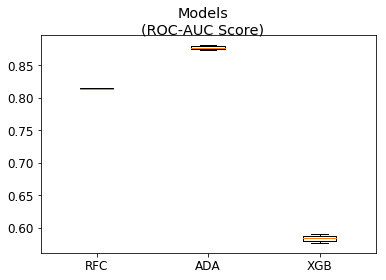

In [10]:
# Let's take a look at these ROC-AUC scores on a box plot
plt.rcParams['font.size'] = 12
fig = plt.figure()
fig.suptitle('Models\n(ROC-AUC Score)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

_All models are pretty stable and the accuracy is very high._

----

# Random Forest Evaluation 

    - ROC curve plot
    - confusion matrix
    - F1Score
    - Feature importance

In [11]:
rf_final.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=60, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

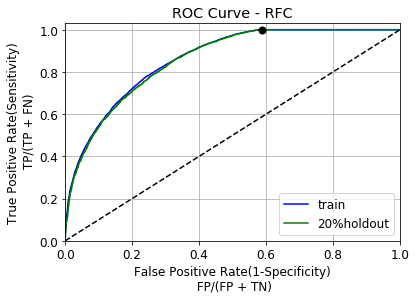

In [12]:
rf_confmtx = confusion_matrix(y_test, rf_final.predict(X_test))
tn, fp, fn, tp = [i for i in rf_confmtx.ravel()]

ypred_train = rf_final.predict_proba(X_train)[:, 1]
ypred_test = rf_final.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, ypred_train)
fpr1, tpr1, thresholds = roc_curve(y_test, ypred_test)
x = fp/(fp+tn)
y = tp/(tp+fn)

plt.plot(fpr, tpr, color='b')
plt.plot(fpr1, tpr1, color='g', label="20%holdout")
plt.plot(x, y, 'ko', markersize=7)
plt.legend(['train', '20%holdout'])
plt.title('ROC Curve - RFC')
plt.xlabel('False Positive Rate(1-Specificity)\n FP/(FP + TN)')
plt.ylabel('True Positive Rate(Sensitivity)\n TP/(TP + FN)')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.03])
plt.grid(True)
plt.plot([0, 1], [0, 1], 'k--')
# plt.tight_layout()
plt.show()

Precision:	0.8550
Recall:		1.0000
F1 Score:	0.9218


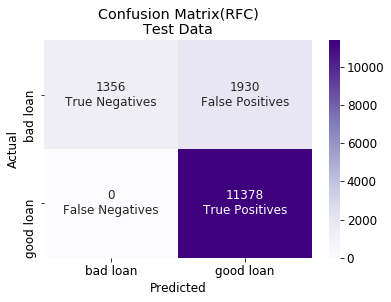

In [13]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2*(precision * recall) / (precision + recall)
print('Precision:\t{:.4f}\nRecall:\t\t{:.4f}\nF1 Score:\t{:.4}'.format(
    precision, recall, f1))


plt.rcParams['font.size'] = 12
plt.subplot(111)
ax = sns.heatmap(rf_confmtx, annot=True, cmap='Purples',
                 annot_kws={"size": 12}, fmt='g')
labels = ['True Negatives', 'False Positives',
          'False Negatives', 'True Positives']
for k, v in enumerate(ax.texts):
    v.set_text(v.get_text() + "\n" + labels[k])
plt.title('Confusion Matrix(RFC)\nTest Data')
ax.xaxis.set_ticklabels(['bad loan', 'good loan'])
ax.yaxis.set_ticklabels(['bad loan', 'good loan'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [14]:
headers = ["feature", "score"]
values = sorted(
    zip(X_train.columns, rf_final.feature_importances_), key=lambda x: x[1] * -1)
dfFeat = pd.DataFrame(np.array(values), columns=list(headers))
dfFeat.head(10)

,feature,score
0,out_prncp,0.6809197185071182
1,months_since_last_credit_pull_d,0.14571566139777808
2,loan_amnt,0.03580831808506818
3,term,0.029568101077376514
4,months_since_issue_d,0.029231410954279467
5,avg_cur_bal,0.014288020731389146
6,home_ownership,0.011702849606885628
7,mo_sin_old_rev_tl_op,0.008079962546866439
8,all_util,0.007331748510211386
9,bc_util,0.0069852573654354795


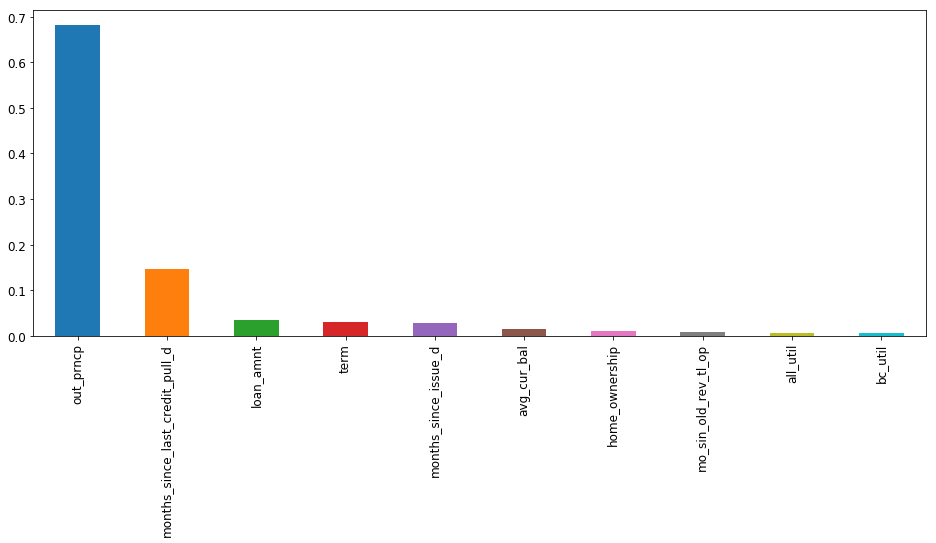

In [15]:
plt.figure(figsize=(16, 6))
feat_importances = pd.Series(
    rf_final.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='bar')

# Random Forest with ADABoost Evaluation 

    - ROC curve plot
    - confusion matrix
    - F1Score
    - Feature importance

In [16]:
ada_final.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=60, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          learning_rate=1.0, n_estimators=8, random_state=None)

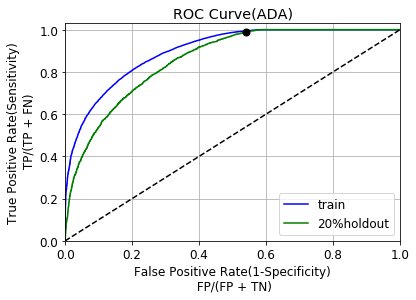

In [17]:
ada_confmtx = confusion_matrix(y_test, ada_final.predict(X_test))
tn2, fp2, fn2, tp2 = [i for i in ada_confmtx.ravel()]


ypred_train = ada_final.predict_proba(X_train)[:, 1]
ypred_test = ada_final.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, ypred_train)
fpr2, tpr2, thresholds = roc_curve(y_test, ypred_test)
x2 = fp2/(fp2+tn2)
y2 = tp2/(tp2+fn2)
plt.plot(fpr, tpr, color='b')
plt.plot(fpr1, tpr1, color='g', label="20%holdout")
plt.plot(x2, y2, 'ko', markersize=7)
plt.legend(['train', '20%holdout'])
plt.title('ROC Curve(ADA)')
plt.xlabel('False Positive Rate(1-Specificity)\n FP/(FP + TN)')
plt.ylabel('True Positive Rate(Sensitivity)\n TP/(TP + FN)')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.03])
plt.grid(True)
plt.plot([0, 1], [0, 1], 'k--')
# plt.tight_layout()
plt.show()

Precision:	0.8642
Recall:		0.9913
F1 Score:	0.9234


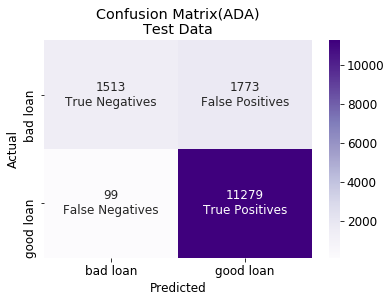

In [30]:
precision_ada = tp2 / (tp2 + fp2)
recall_ada = tp2 / (tp2 + fn2)
f1_ada = 2*(precision_ada * recall_ada) / (precision_ada + recall_ada)
print('Precision:\t{:.4f}\nRecall:\t\t{:.4f}\nF1 Score:\t{:.4}'.format(
    precision_ada, recall_ada, f1_ada))

plt.rcParams['font.size'] = 12
plt.subplot(111)
ax = sns.heatmap(ada_confmtx, annot=True, cmap='Purples',
                 annot_kws={"size": 12}, fmt='g')
labels = ['True Negatives', 'False Positives',
          'False Negatives', 'True Positives']
for k, v in enumerate(ax.texts):
    v.set_text(v.get_text() + "\n" + labels[k])
plt.title('Confusion Matrix(ADA)\nTest Data')
ax.xaxis.set_ticklabels(['bad loan', 'good loan'])
ax.yaxis.set_ticklabels(['bad loan', 'good loan'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();

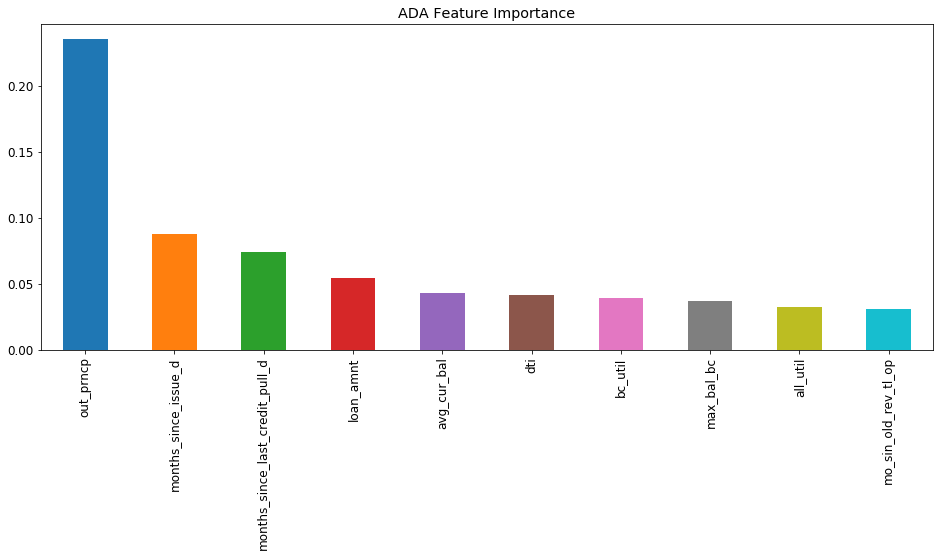

In [26]:
plt.figure(figsize=(16, 6))
plt.title('ADA Feature Importance')

feat_ada = pd.Series(
    ada_final.feature_importances_, index=X_train.columns)
feat_ada.nlargest(10).plot(kind='bar')

In [20]:
# The top ten features that will be used in the unsupervised learning notebook
feat_ada.nlargest(10)

out_prncp                          0.235170
months_since_issue_d               0.088112
months_since_last_credit_pull_d    0.074210
loan_amnt                          0.054365
avg_cur_bal                        0.043216
dti                                0.041361
bc_util                            0.039423
max_bal_bc                         0.036797
all_util                           0.032263
mo_sin_old_rev_tl_op               0.031290
dtype: float64

# XGB Evaluation 

    - ROC curve plot
    - confusion matrix
    - F1Score
    - Feature importance

In [21]:
# Print the ROC curve
#ax = fig.add_subplot(2, 2, 2)
xgb_final.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.0001,
       colsample_bytree=0.001, gamma=0, learning_rate=1e-05,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=5, n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.1)

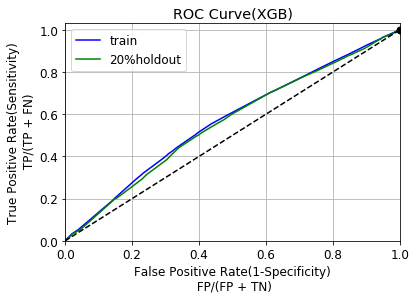

In [22]:
xgb_confmtx = confusion_matrix(y_test, xgb_final.predict(X_test))
tn1, fp1, fn1, tp1 = [i for i in xgb_confmtx.ravel()]


ypred_train = xgb_final.predict_proba(X_train)[:, 1]
ypred_test = xgb_final.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, ypred_train)
fpr1, tpr1, thresholds = roc_curve(y_test, ypred_test)
x1 = fp1/(fp1+tn1)
y1 = tp1/(tp1+fn1)
plt.plot(fpr, tpr, color='b')
plt.plot(fpr1, tpr1, color='g', label="20%holdout")
plt.plot(x1, y1, 'ko', markersize=7)
plt.legend(['train', '20%holdout'])
plt.title('ROC Curve(XGB)')
plt.xlabel('False Positive Rate(1-Specificity)\n FP/(FP + TN)')
plt.ylabel('True Positive Rate(Sensitivity)\n TP/(TP + FN)')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.03])
plt.grid(True)
plt.plot([0, 1], [0, 1], 'k--')
# plt.tight_layout()
plt.show()

As we saw with the accuracy score, XGB was not able to perform better than the baseline.  And we see that with the ROC curve. The true postitives are increasing just as fast that the false positives.

Precision:	0.7759
Recall:		1.0000
F1 Score:	0.8738


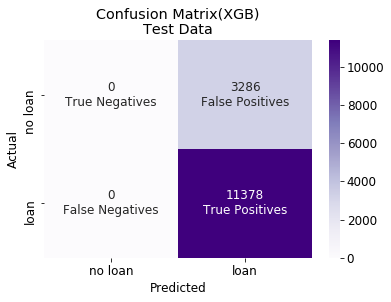

In [23]:
xbg_confmtx = confusion_matrix(y_test, xgb_final.predict(X_test))
tn1, fp1, fn1, tp1 = [i for i in xbg_confmtx.ravel()]
precision1 = tp1 / (tp1 + fp1)
recall1 = tp1 / (tp1 + fn1)
xgb_f1 = 2*(precision1 * recall1) / (precision1 + recall1)
print('Precision:\t{:.4f}\nRecall:\t\t{:.4f}\nF1 Score:\t{:.4f}'.format(
    precision1, recall1, xgb_f1))

# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix#51163585
# https://tatwan.github.io/How-To-Plot-A-Confusion-Matrix-In-Python/
plt.rcParams['font.size'] = 12
plt.subplot(111)
ax = sns.heatmap(xbg_confmtx, annot=True, cmap='Purples',
                 annot_kws={"size": 12}, fmt='g')
labels = ['True Negatives', 'False Positives',
          'False Negatives', 'True Positives']
#classNames = ['Negative','Positive']
#tick_marks = np.arange(len(classNames))
#plt.xticks(tick_marks, classNames)
#plt.yticks(tick_marks, classNames)
for k, v in enumerate(ax.texts):
    v.set_text(v.get_text() + "\n" + labels[k])
plt.title('Confusion Matrix(XGB)\nTest Data')
ax.xaxis.set_ticklabels(['no loan', 'loan'])
ax.yaxis.set_ticklabels(['no loan', 'loan'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();

_When using the cross validation the precision = 80.44% and Recall is 99.96% but when computing them via the confusion mattris the Precision is 78.65% and the Recall is 100%


`Precision = tp * tp+fp`

High precision means that an algorithm returned substantially more relevant results than irrelevant ones

`Recall = tp*tp+fn`

High recall means that an algorithm returned most of the relevant results.



---

___XGB Feture Importance___

In [24]:
xgb_fea_imp = pd.DataFrame(list(xgb_final.get_booster().get_fscore().items()),
                           columns=['feature', 'importance']).sort_values('importance', ascending=False)

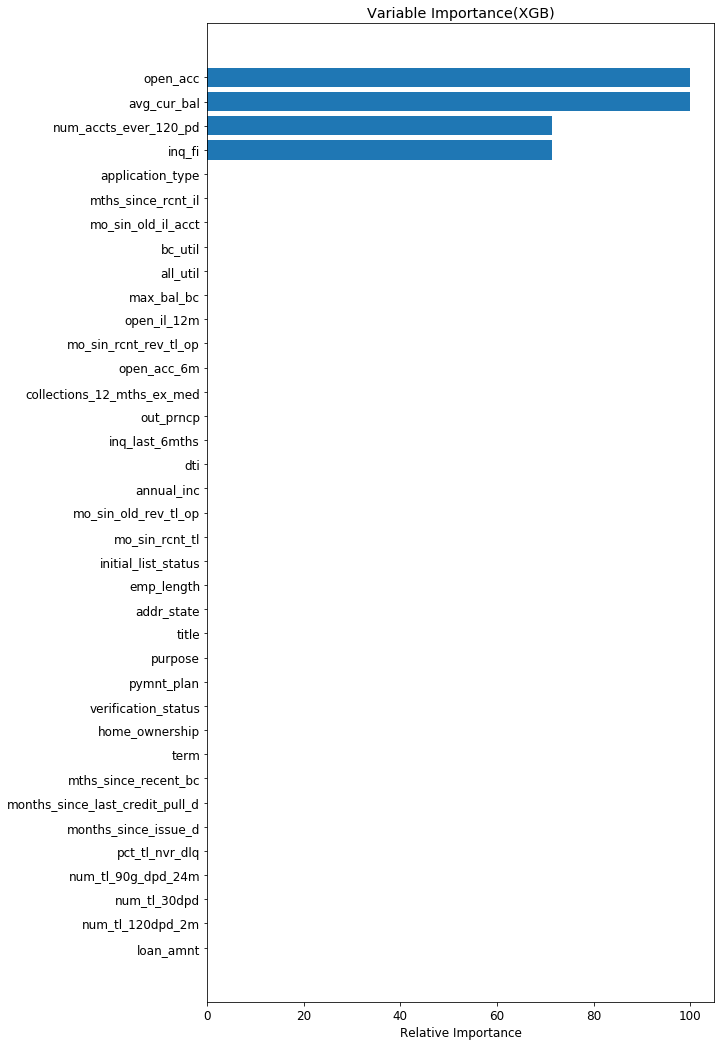

In [25]:
fig = plt.figure(figsize=(20, 18))
feature_importance = xgb_final.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance(XGB)')
plt.show()

So we now see there are only 4 significant features for XGB.  This needs to be retuned or ran without PCA.

# Conclusion
The model is able to predict that a loan will be paid back 80% of the time.  RFC miscladssified 2,315 loans while XGB 1,875 loans.  ADA boost was use on the tuned RFC model and increased the accuracy a little.  But all models had a weighted average of ~85%.  For all the models comparing their cross validation scores with the accuracy score the models are not over or under fit. 

The models can be tuned more by dropping more of the features that don't even rank in feature importance as we see in the RFC plot above.  And for the XGB model, there is one feature that out weighs all the features that we may need to remove and run the model again.

If I have time I will drop the features and see if I can increase the accuracy scores.
